# ENVIROMENT SETTING

In [1]:
# Octopus ML pakage - github.com/gershonc/octopus-ml
!pip install octopus-ml

In [2]:
# COLAB ONLY
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import octopus_ml as oc
import sklearn as sk

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn import preprocessing
from sklearn import ensemble
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,roc_curve, auc, confusion_matrix
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA, TruncatedSVD

from multiprocessing.pool import ThreadPool
from multiprocessing import Pool 
from scipy.stats import ks_2samp

from xgboost import XGBClassifier
# from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

#### Data loading

In [4]:
folder_path = '/content/drive/MyDrive/Data/colabs_data/WiDS' #Kaggle: ../input/widsdatathon2021/ #Local PC: '.'
df_train = pd.read_csv(folder_path + "/TrainingWiDS2021.csv")
df_test = pd.read_csv(folder_path + "/UnlabeledWiDS2021.csv")
print(df_train.shape)
print(df_test.shape)

(130157, 181)
(10234, 180)


#### Feature classification
Phân loại các loại nhãn dữ liệu cần xử lý


In [5]:
# Data type 
col_target = 'diabetes_mellitus'
cols_id = ['encounter_id', 'Unnamed: 0']
cols_cat = [i for i in df_train.select_dtypes('object').columns if i not in cols_id + [col_target]]
cols_num = [i for i in df_train if i not in cols_cat + cols_id + [col_target] ]
cols_ft = cols_cat + cols_num

# BASELINE DATA PIPELINE
Chạy model mà không thêm feature

In [ ]:
# Model 1: baseline, không bổ sung feature, model đơn giản
p_cat = Pipeline([
  ('imputer', SimpleImputer(strategy='constant', fill_value='missing')) ,
  ('encode', preprocessing.OrdinalEncoder())
])
p_num = Pipeline([
  ('fillna', SimpleImputer(strategy='constant', fill_value= -10000))
])
p1 = ColumnTransformer([
  ('cat', p_cat, cols_cat),
  ('num', p_num, cols_num)
])

pipe = Pipeline([
  ('transformer', p1),
  ('predictor', XGBClassifier(n_estimators= 100, n_jobs= -1, max_depth = 5 ))
])

cv_auc = cross_val_score( pipe, df_train[cols_ft], df_train[col_target], 
                         cv = 5, scoring = 'roc_auc', verbose = 1, n_jobs = -1)
pipe.fit(df_train[cols_ft], df_train[col_target])

print(cv_auc)
print(np.mean(cv_auc))
# [0.85000521 0.84067354 0.83726405 0.7301786  0.8296305 ]
# => AUC at CV: 0.8175503796337711
# => AUC at LB: 0.70188

In [6]:
# Model 2: baseline, model đã turning, feature đơn giản
p_cat = Pipeline([
  ('imputer', SimpleImputer(strategy='constant', fill_value='missing')) ,
  ('encode', preprocessing.OrdinalEncoder())
])
p_num = Pipeline([
  ('fillna', SimpleImputer(strategy='constant', fill_value= -10000))
])
p1 = ColumnTransformer([
  ('cat', p_cat, cols_cat),
  ('num', p_num, cols_num)
])

pipe = Pipeline([
  ('transformer', p1),
])

X = pd.DataFrame(data = pipe.fit_transform( df_train[cols_ft]), columns= cols_ft)
y = df_train[col_target]

# Turning model
params = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'auc',
        'learning_rate': 0.007,
        'subsample': 1,
        'colsample_bytree': 0.25,
        'reg_alpha': 3,
        'reg_lambda': 1,
        'scale_pos_weight': 3,
        'n_estimators': 10000,
        'verbose': 1,
        'max_depth': -1,
        'seed':100, 
        'force_col_wise': True

}

clf,arr_f1_weighted,arr_f1_macro,arr_f1_positive,prediction_folds,preds_folds,y_folds= oc.cv(
    X, y,
    0.5,16000,shuffle=True,params=params)

# => AUC at CV: 
# => AUC at LB: 

0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
5it [39:55, 479.14s/it]

Method Name       : cv
Current memory usage: 9.247715MB
Peak                : 571.464596MB
Total time taken:   2395728.788 ms 


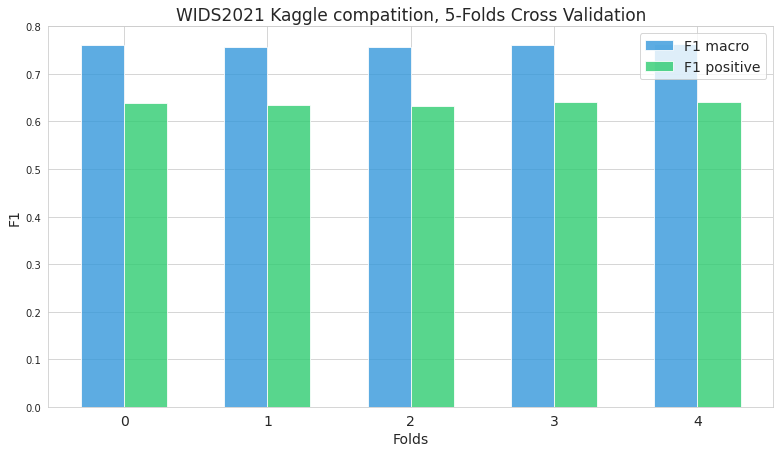

In [7]:
# Model 2
oc.cv_plot(arr_f1_weighted,arr_f1_macro,arr_f1_positive,'WIDS2021 Kaggle compatition')

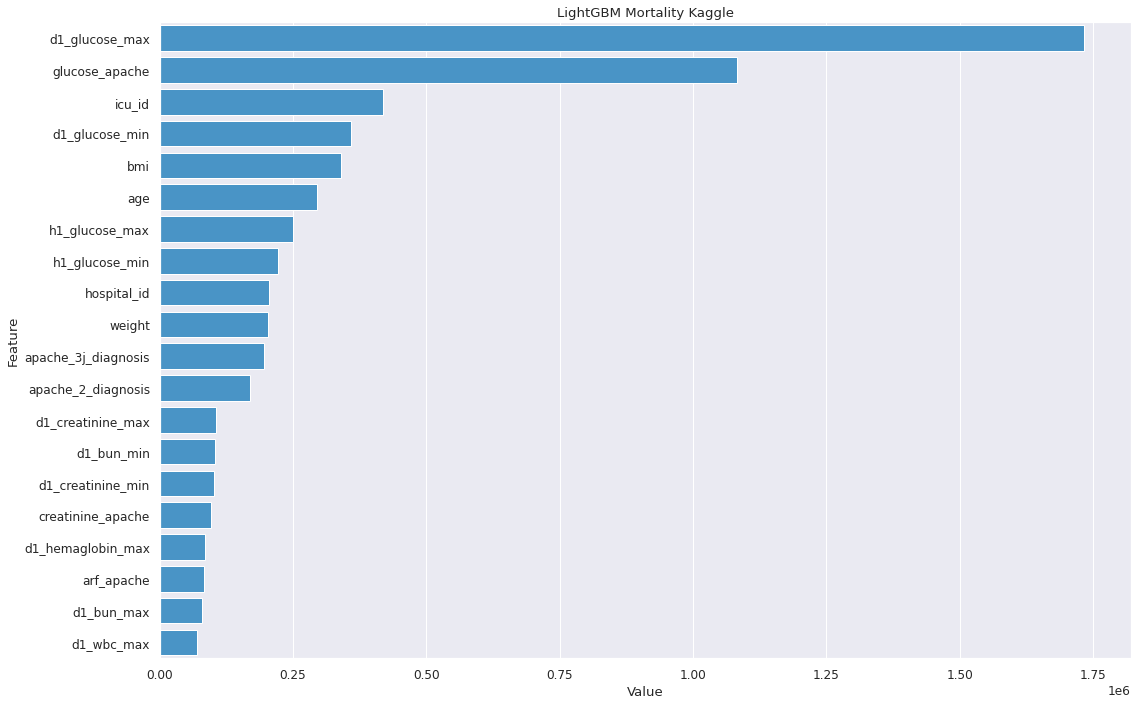

In [8]:
# Model 2
feature_imp_list=oc.plot_imp(clf,X,'LightGBM Mortality Kaggle',num=20)

# DATA PROCESSING
Prepare and transform data

## ADD DERIVED FEATURES

# MODEL TURNING

# SUBMISSION

In [10]:
df_test['diabetes_mellitus'] = clf.predict(pipe.transform( df_test[cols_ft]))
df_ss = df_test[['encounter_id', 'diabetes_mellitus']]
df_ss.to_csv('./submission.csv', index = False)

## CHECK ERROR

In [ ]:
for i in cols_cat:
  test_and_not_train = [t for t in df_test[i].unique() if t not in df_train[i].unique()]
  if len(test_and_not_train) !=0:
    print('column with value in test data but not train: ', i, ' ; \n value: ', test_and_not_train)
  train_and_not_test = [t for t in df_train[i].unique() if t not in df_test[i].unique()]
  if len(train_and_not_test) != 0:
    print('column with value in train data but not test: ', i, ' ; \n value: ', train_and_not_test)


column with value in test data but not train:  ethnicity  ; 
 value:  [nan]
column with value in train data but not test:  ethnicity  ; 
 value:  [nan]
column with value in test data but not train:  gender  ; 
 value:  [nan]
column with value in train data but not test:  gender  ; 
 value:  [nan]
column with value in test data but not train:  hospital_admit_source  ; 
 value:  [nan]
column with value in train data but not test:  hospital_admit_source  ; 
 value:  [nan, 'Acute Care/Floor', 'PACU', 'Observation', 'ICU', 'Other']
column with value in test data but not train:  icu_admit_source  ; 
 value:  [nan]
column with value in train data but not test:  icu_admit_source  ; 
 value:  [nan]


In [ ]:
# hospital_admit_source  
print(df_train['hospital_admit_source'].unique())
print(df_test['hospital_admit_source'].unique())

['Floor' 'Emergency Department' 'Operating Room' nan 'Direct Admit'
 'Other Hospital' 'Other ICU' 'ICU to SDU' 'Recovery Room'
 'Chest Pain Center' 'Step-Down Unit (SDU)' 'Acute Care/Floor' 'PACU'
 'Observation' 'ICU' 'Other']
['Floor' 'Emergency Department' 'Direct Admit' nan 'Operating Room'
 'Other Hospital' 'Other ICU' 'ICU to SDU' 'Recovery Room'
 'Step-Down Unit (SDU)' 'Chest Pain Center']


In [ ]:
df_train[i].unique()

array(['CTICU', 'Med-Surg ICU', 'CCU-CTICU', 'Neuro ICU', 'MICU', 'SICU',
       'Cardiac ICU', 'CSICU'], dtype=object)

In [ ]:
'CTICU' not in df_test[i].unique()

False

In [ ]:
# # Kiểm tra vì sao pipe bị lỗi
# pipe[0].transformers[0][1].fit(df_train[cols_cat])
# pipe[0].transformers[0][1].transform(df_test[cols_cat])
# # =>cat pipe work well
# pipe[0].transformers[1][1].fit(df_train[cols_num])
# pipe[0].transformers[1][1].transform(df_test[cols_num])
# # =>num pipe work well

# pipe[0].fit(df_train[cols_ft])
# pipe[0].transform(df_test[cols_ft])
# # # => all pipe work well

array([[ 2.,  0.,  4., ...,  0.,  0.,  0.],
       [ 2.,  0.,  3., ...,  0.,  0.,  0.],
       [ 2.,  0.,  4., ...,  0.,  0.,  0.],
       ...,
       [ 2.,  0., 14., ...,  0.,  0.,  0.],
       [ 2.,  0.,  3., ...,  0.,  0.,  0.],
       [ 2.,  1.,  3., ...,  0.,  0.,  0.]])

In [ ]:
pipe.predict(df_test[cols_ft])

XGBoostError: ignored